In [1]:
import pyam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the compiled CDR dataset.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Read in the filter sets for land and pe bio that we prepared in the previous notebook.

In [3]:
filter_set_land = pd.read_csv(
    Path(
        '../data/103_filter_set_land.csv'
    ),
    index_col=[0,1]
)

In [4]:
filter_set_bio = pd.read_csv(
    Path(
        '../data/103_filter_set_bio.csv'
    ),
    index_col=[0,1]
)

Step 3: Concatenate the two so that we can assign this to the global CDR dataset.

In [5]:
filter_all = pd.concat(
    [
        filter_set_land,
        filter_set_bio
    ],
    axis=1
)

In [6]:
filter_all_overlap = (
    filter_all
    .loc[
        df.meta.index.intersection(filter_all.index)
    ]
)

Step 4: Create a new metadata column and assign the two sets of netzero values.

In [7]:
filter_all_overlap.columns

Index(['exclude', 'land_cover_max', 'land_cover_netzero', 'land_sustainable',
       'exclude', 'pe_bio_max', 'pe_bio_netzero', 'bio_sustainable'],
      dtype='object')

In [8]:
cols = ['land_cover_netzero', 'pe_bio_netzero']

In [9]:
for c in cols:
    df.set_meta(
        meta=filter_all_overlap[c],
        name=c
    )

Step 5: For each world region, we now want to calculate the cumulative land and novel CDR over two time periods:
* 2020 to global net zero CO2
* Global net zero CO2 to 2100

In [10]:
netzero_year = df.meta.loc[
    :,
    'Year of netzero CO2 emissions (Harm-Infilled) table'
]

In [11]:
netzero_year.fillna(
    2100,
    inplace=True
)

In [12]:
novel_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
conventional_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'

In [13]:
for reg in df.region:
    if reg == 'World':
        continue
    for var in [novel_cdr, conventional_cdr]:
        if var == novel_cdr:
            meta_prefix = 'novel_cdr'
        else:
            meta_prefix = 'conventional_cdr'
        ts_data = (
            df
            .filter(
                region=reg,
                variable=var
            )
            .timeseries()
        )
        # The cumulative estimate to net zero
        df.set_meta(
            meta=ts_data.apply(
               lambda x: pyam.cumulative(
                   x,
                   first_year=2020,
                   last_year=netzero_year[x.name[0:2]]
               ),
               axis=1
            ),
            name=f'{meta_prefix}_{reg}_2020_netzero'
        )
        # The cumulative estimate to 2100
        df.set_meta(
            meta=ts_data.apply(
                lambda x: pyam.cumulative(
                    x,
                    first_year=netzero_year[x.name[0:2]],
                    last_year=2100
                ),
                axis=1
            ),
            name=f'{meta_prefix}_{reg}_netzero_2100'
        )

Step 6: Now, we want a processing function that takes the following information:
* The column to categorise by
* Bins
* Bin labels

And then returns a melted dataframe with the categories that are ready to plot.

In [14]:
def process_data(
        col,
        bins,
        bin_labels
):
    """Helper function to process and bin data"""
    df.meta.loc[:, f'category_{col}'] = (
        pd.cut(
            df.meta.loc[:, col],
            bins=bins
        )
        .map(bin_labels)
    )
    # Step 6.1: Decide which columns need to be melted.
    cols_to_melt = [
        x for x in df.meta.columns if 'novel_cdr' in x or 'conventional_cdr' in x
    ]
    # Step 6.2: Melt the dataframe
    melted_data = (
        pd.melt(
            frame=df.meta.reset_index(),
            id_vars=['model', 'scenario', 'Category', f'category_{col}'],
            value_vars=cols_to_melt
        )
    )
    # Step 6.3: Split the variable column
    melted_data['variable'] = melted_data['variable'].apply(
        lambda x: x.replace('cdr', 'cdr_World') if 'R5' not in x else x
    )
    melted_data.loc[:, 'cdr_type'] = melted_data['variable'].apply(
        lambda x: x.split('_')[0] + '_' + x.split('_')[1]
    )
    melted_data.loc[:, 'region'] = melted_data['variable'].apply(
        lambda x: x.split('_')[2]
    )
    melted_data.loc[:, 'timeframe'] = melted_data['variable'].apply(
        lambda x: x.split('_')[3] + '_' + x.split('_')[4]
    )
    return melted_data

Step 7: Let us start with the land area filters.

In [15]:
bins_for_land = (
    pd
    .IntervalIndex
    .from_tuples(
        [
            (0, 100),
            (100, 400),
            (400, 2000)
        ]
    )
)
land_labels = dict(
    zip(
        bins_for_land,
        [
            '0-100',
            '100-400',
            '400+'
        ]
    )
)
land_estimates = process_data(
    col='land_cover_netzero',
    bins=bins_for_land,
    bin_labels=land_labels
)

Step 8: Now let us move on to the bioenergy demand filters.

In [16]:
bins_for_pe = (
    pd
    .IntervalIndex
    .from_tuples(
        [
            (0, 100),
            (100, 200),
            (200, 1000)
        ]
    )
)
pe_labels = dict(
    zip(
        bins_for_pe,
        [
            '0-100',
            '100-200',
            '200+'
        ]
    )
)
bio_estimates = process_data(
    col='pe_bio_netzero',
    bins=bins_for_pe,
    bin_labels=pe_labels
)

Step 9: Write this out for further processing.

In [17]:
land_estimates.to_csv(
    Path(
        '../data/105_land_categories.csv'
    )
)

In [18]:
bio_estimates.to_csv(
    Path(
        '../data/105_bio_categories.csv'
    )
)

matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='year', ylabel='Gt CO2/yr'>

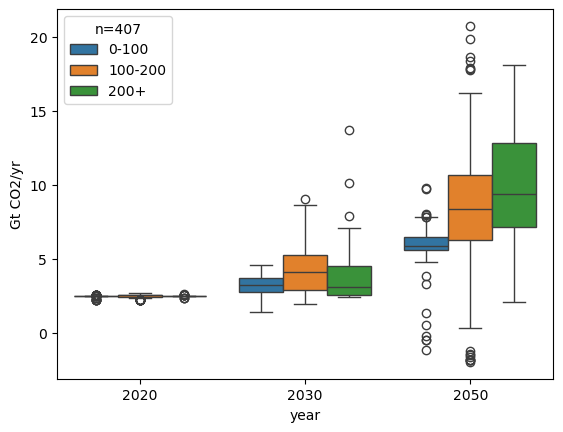

In [26]:
df.filter(
    region='World',
    variable='*Carbon Removal|Total',
    year=[2020, 2030, 2050]
).plot.box(by='category_pe_bio_netzero')